<a href="https://colab.research.google.com/github/ifeLight/ml-bot/blob/main/binance-multi-timeframe-grade-review_v1_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas-ta
!pip install backtrader[plotting]
!pip install plotly
!pip install --upgrade firebase-admin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=5b99fab2f081c904aecad8d3132a1d3980a134a05014f3a3c05296737f96d52d
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.0/134.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: firebase-admin
    Found existing installation: firebase-admin 6.6.0
    Uninstalling firebase-admin-6.6.0:
      Successfully uninstalled firebase-admin-6.6.0


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import requests
import json
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import backtrader as bt
import pandas_ta as ta
from imblearn.over_sampling import SMOTE
import subprocess
import firebase_admin
from firebase_admin import firestore
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
from google.colab import auth
import google.auth
import itertools
import hashlib

In [3]:
auth.authenticate_user()
#Configure Google cloud project
project_id = 'ifelight'
!gcloud config set project {project_id}

Updated property [core/project].


In [4]:
# Working GCP Bucket name
bucket_name = 'ife-storage'
# Working on Firestore name
firestore_collection_name = 'trade-models'

In [5]:
binance_base_url = 'https://52on3577u3.execute-api.eu-central-1.amazonaws.com'

def get_binance_candles(symbol: str, interval='1h', limit: int = 50, **kwargs):
    url = f'{binance_base_url}/api/v3/uiKlines?symbol={symbol}&interval={interval}&limit={limit}'
    for key, value in kwargs.items():
        url += f'&{key}={value}'
    response = requests.get(url)
    result = json.loads(response.text)
    # print(result)
    def map_result(x):
        return {
            'Date': x[0],
            'Open': x[1],
            'High': x[2],
            'Low': x[3],
            'Close': x[4],
            'Volume': x[5],
        }
    mappeded_result = []
    for x in result:
        mappeded_result.append(map_result(x))
    return mappeded_result


def candles_to_df(data):
    df =  pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'], unit='ms')
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    df.set_index('Date', inplace=True)
    return df

def get_all_binance_candles(symbol: str, interval='1h', start_date=None, end_date=None, limit=1000):
  try:
    return load_candles_from_cloud_storage(symbol, interval, start_date, end_date)
  except FileNotFoundError:
    pass
  result = []
  raw_start_date = start_date
  raw_end_date = end_date
  start_date = pd.to_datetime(start_date) if start_date else pd.to_datetime('2015-01-01')
  end_date = pd.to_datetime(end_date) if end_date else pd.to_datetime('today')
  while True:
    candles = get_binance_candles(symbol, interval, limit, startTime=int(start_date.timestamp() * 1000), endTime=int(end_date.timestamp() * 1000))
    if len(candles) <= 1:
      break;
    result += candles
    start_date = pd.to_datetime(datetime.datetime.fromtimestamp(candles[-1]['Date'] / 1000))
  candles_df = candles_to_df(result)
  save_candles_to_cloud_storage(candles_df, symbol, interval, raw_start_date, raw_end_date)
  return candles_df

def candles_storage_file_name(symbol: str, interval='1h', start_date=None, end_date=None):
  file_name = f'binance_{symbol}_{interval}_{start_date}_{end_date}.csv'
  return file_name

def load_candles_from_cloud_storage(symbol: str, interval: str, start_date=None, end_date=None):
  file_name = candles_storage_file_name(symbol, interval, start_date, end_date)
  try:
    # Download the file from cloud storage.
    subprocess.run(['gsutil', 'cp', f'gs://{bucket_name}/trade/candles/{file_name}', f'/tmp/{file_name}'], check=True)

    # Load the data into a Pandas DataFrame.
    with open(f'/tmp/{file_name}', 'r') as f:
      return pd.read_csv(f, index_col=0, parse_dates=True)
  except subprocess.CalledProcessError:
    # Raise a FileNotFoundError if the file is not found in cloud storage.
    raise FileNotFoundError(f"File not found: gs://{bucket_name}/trade/candles/{file_name}")

def save_candles_to_cloud_storage(df: pd.DataFrame, symbol: str, interval: str, start_date, end_date):
  file_name = candles_storage_file_name(symbol, interval, start_date, end_date)
  df.to_csv(f'/tmp/{file_name}')
  !gsutil cp /tmp/{file_name} gs://{bucket_name}/trade/candles/{file_name}


In [6]:
def add_scaled_rsi(df, window=14, prefix = '', features_columns=[]):
  series = ta.rsi(df['Close'], length=window)
  column_name = f"{prefix}RSI_{window}"
  df[column_name] = series / 100
  if(column_name not in features_columns):
    features_columns.append(column_name)
  return df

def add_scaled_ema(df, window=50, prefix = '', features_columns=[]):
  series = ta.ema(df['Close'], length=window)
  column_name = f"{prefix}EMA_{window}"
  df[column_name] = series / df['Close']
  if column_name not in features_columns:
    features_columns.append(column_name)
  return df

def add_scaled_sma(df, window=50, prefix = '', features_columns=[]):
  series = ta.sma(df['Close'], length=window)
  column_name = f"{prefix}SMA_{window}"
  df[column_name] = series / df['Close']
  if column_name not in features_columns:
    features_columns.append(column_name)
  return df

def add_scaled_macd(df, prefix= '', features_columns=[], fast = 12, slow = 26, signal=9):
  macd_df = ta.macd(df['Close'], fast=fast, slow=slow, signal=signal)
  suffix = f"{fast}_{slow}_{signal}"
  macd_column_name = f"{prefix}MACD_{suffix}"
  macds_column_name = f"{prefix}MACDs_{suffix}"
  macdh_column_name = f"{prefix}MACDh_{suffix}"
  df[macd_column_name] = macd_df[macd_df.columns[0]] / df['Close']
  df[macds_column_name] = macd_df[macd_df.columns[2]] / df['Close']
  df[macdh_column_name] = macd_df[macd_df.columns[1]] / df['Close']
  if macd_column_name not in features_columns:
    features_columns.append(macd_column_name)
  if macds_column_name not in features_columns:
    features_columns.append(macds_column_name)
  if macdh_column_name not in features_columns:
    features_columns.append(macdh_column_name)
  return df

def add_scaled_bbands(df, window=20, std=2.0, prefix= '', features_columns=[]):
  bbands_df = ta.bbands(df['Close'], length=window, std=std)
  suffix = f"{window}_{std}"
  bbl_column_name = f"{prefix}BBL_{suffix}"
  bbm_column_name = f"{prefix}BBM_{suffix}"
  bbu_column_name = f"{prefix}BBU_{suffix}"
  bbb_column_name = f"{prefix}BBB_{suffix}"
  bbp_column_name = f"{prefix}BBP_{suffix}"
  df[bbl_column_name] = bbands_df[bbands_df.columns[0]] / df['Close']
  df[bbm_column_name] = bbands_df[bbands_df.columns[1]] / df['Close']
  df[bbu_column_name] = bbands_df[bbands_df.columns[2]] / df['Close']
  df[bbb_column_name] = bbands_df[bbands_df.columns[3]]
  df[bbp_column_name] = bbands_df[bbands_df.columns[4]]
  if bbl_column_name not in features_columns: features_columns.append(bbl_column_name)
  if bbm_column_name not in features_columns: features_columns.append(bbm_column_name)
  if bbu_column_name not in features_columns: features_columns.append(bbu_column_name)
  if bbb_column_name not in features_columns: features_columns.append(bbb_column_name)
  if bbp_column_name not in features_columns: features_columns.append(bbp_column_name)
  return df

In [7]:
def merge_candlesticks_data(df1, df2):
  """
  Merges two candlestick DataFrames with forward fill, handling different timeframes,
  and prevents duplicate OHLCV columns.
  Ensure both DataFrames have a datetime index.
  And ensure the second DataFrame is the larger timeframe

  Args:
      df1: First candlestick DataFrame with datetime index.
      df2: Second candlestick DataFrame with datetime index.

  Returns:
      Merged DataFrame with forward-filled values, and no duplicate OHLCV columns.
  """
  # Ensure both DataFrames have a datetime index
  if not isinstance(df1.index, pd.DatetimeIndex) or not isinstance(df2.index, pd.DatetimeIndex):
      raise ValueError("DataFrames must have a datetime index.")
  # Identify OHLCV columns
  ohlcv_cols = ['open', 'high', 'low', 'close', 'volume']

  # Rename columns in df2 that conflict with df1's OHLCV columns
  for col in df2.columns:
    if col.lower() in ohlcv_cols and col.lower() in df1.columns.str.lower():
      del df2[col]

  # Merge the DataFrames using outer join, which preserves all dates
  merged_df = pd.merge(df1, df2, how='outer', left_index=True, right_index=True, suffixes=('_df1', '_df2'))

  # Forward fill the missing values for each column
  for col in merged_df.columns:
    merged_df[col] = merged_df[col].ffill()

  return merged_df

In [8]:
def resample_candles(df, interval='1h'):
    return df.resample(interval).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).ffill()

In [9]:
def predict_in_batches(model, test_data, features_columns, seq_length, batch_size=128):
    """
    Predicts in batches to speed up inference.
    """
    num_samples = len(test_data) - seq_length
    feature_array = test_data[features_columns].values
    predicted_values = np.full(len(test_data), np.nan)

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = range(start_idx + seq_length, end_idx + seq_length)
        batch_input = np.array([feature_array[i - seq_length:i] for i in batch_indices])

        if len(batch_input) > 0 :
            predictions = model.predict(batch_input, verbose=0)
            predicted_values[batch_indices] = predictions.flatten() #Flatten to 1d array.

    test_data['Predicted_Value'] = predicted_values
    return test_data

In [11]:
class PredictedValueStrategy(bt.Strategy):
    params = (
        ('buy_threshold', 0.6),
        ('sell_threshold', 0.6),
        ('leverage', 1),  # Leverage ratio
        ('margin', 1000),
        ('log', True)
    )

    def __init__(self):
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add the Predicted_Value as a data feed
        self.predicted_value = self.datas[0].predicted_value

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
         # # Check if we are in the market
        if not self.position:
          cash = self.broker.getcash()
          position_size = (self.params.margin * self.params.leverage) / self.data.close[0]
          # Long signal
          if self.predicted_value[0] > self.params.buy_threshold:
            self.log('LONG POSITION CREATED, %.2f' % self.datas[0].close[0])
            self.order = self.buy(size=position_size)

          # Short signal
          elif self.predicted_value[0] < self.params.sell_threshold:
            self.log('SHORT POSITION CREATED, %.2f' % self.datas[0].close[0])
            self.order = self.sell(size=position_size)

        else:
          if self.predicted_value[0] > self.params.buy_threshold and self.position.size < 0:
            self.log('CLOSE SHORT POSITION CREATED, %.2f' % self.datas[0].close[0])
            self.order = self.close()
          elif self.predicted_value[0] < self.params.sell_threshold and self.position.size > 0:
            self.log('CLOSE LONG POSITION CREATED, %.2f' % self.datas[0].close[0])
            self.order = self.close()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log('Order Canceled')
            elif order.status == order.Margin:
                self.log(f'Order Margin Not Enough - Available cash: {self.broker.getcash()}')
            elif order.status == order.Rejected:
                self.log('Order Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'TRADE COMPLETED, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}, Available Cash {self.broker.getcash():.2f}')

    def log(self, txt, dt=None):
        if not self.params.log:
          return
        dt = dt or self.datas[0].datetime.date(0)
        time = self.datas[0].datetime.time()
        print(f'{dt.isoformat()} {time.isoformat()}, {txt}')


In [12]:
# Extend PandasData to include the custom column
class CustomPandasData(bt.feeds.PandasData):
    # Add custom columns
    lines = ('predicted_value',)  # Add the custom line
    params = (
        ('predicted_value', 'Predicted_Value'),  # Map the column name
    )


In [ ]:
def simulate_strategy(df, index):
  # TODO
  item = df.loc[index]

In [14]:
def get_model_cloud_storage_path(bucket_name, local_file_name):
    """
    Returns the cloud storage path for a given model name.

    Parameters:
        local_file_name (str): The name of the model.

    Returns:
        str: The cloud storage path. (e.g., gs://<bucket_name>/trade/models/<model_name>.h5).
    """
    return f'gs://{bucket_name}/trade/models/{local_file_name}'

def save_model_to_cloud_storage(model: tf.keras.Model, model_name: str, bucket_name: str):
    """
    Saves a TensorFlow model to Google Cloud Storage and returns the cloud storage file path.

    Parameters:
        model (tf.keras.Model): The TensorFlow model to save.
        model_name (str): The name of the model (used to create the file name).
        bucket_name (str): The name of the Google Cloud Storage bucket.

    Returns:
        str: The cloud storage file path (e.g., gs://<bucket_name>/trade/models/<model_name>.h5).
    """
    # Define the local and cloud storage file paths
    local_file_name = f'{model_name}.h5'
    local_file_path = f'/tmp/{local_file_name}'
    cloud_file_path = get_model_cloud_storage_path(bucket_name, local_file_name)

    # Save the model locally
    model.save(local_file_path)

    try:
        # Upload the model to Google Cloud Storage
        subprocess.run(['gsutil', 'cp', local_file_path, cloud_file_path], check=True)
        print(f"Model saved to {cloud_file_path}")
    except subprocess.CalledProcessError as e:
        # Handle errors during the upload process
        raise RuntimeError(f"Failed to upload model to Google Cloud Storage: {e}")
    finally:
        # Clean up the local file
        if os.path.exists(local_file_path):
            os.remove(local_file_path)
    return cloud_file_path

def load_model_from_cloud_storage(model_name: str, bucket_name: str):
    """
    Loads a TensorFlow model from Google Cloud Storage.

    Parameters:
        model_name (str): The name of the model (used to create the file name).
        bucket_name (str): The name of the Google Cloud Storage bucket.

    Returns:
        tf.keras.Model: The loaded TensorFlow model.
    """
    # Define the local and cloud storage file paths
    local_file_name = f'{model_name}.h5'
    local_file_path = f'/tmp/{local_file_name}'
    cloud_file_path = get_model_cloud_storage_path(bucket_name, local_file_name)

    try:
        # Download the model from Google Cloud Storage
        subprocess.run(['gsutil', 'cp', cloud_file_path, local_file_path], check=True)

        # Load the model
        model = tf.keras.models.load_model(local_file_path)
        print(f"Model loaded from {cloud_file_path}")
        return model
    except subprocess.CalledProcessError as e:
        raise FileNotFoundError(f"Model not found in Google Cloud Storage: {e}")
    finally:
        # Clean up the local file
        if os.path.exists(local_file_path):
            os.remove(local_file_path)


In [15]:
def initialize_firestore(project_id):
    """
    Initialize the Firestore client using the service account key.

    Parameters:
        project_id (str): The Google Cloud project ID.

    Returns:
        firestore.Client: Initialized Firestore client.
    """
    if not firebase_admin._apps:
        # cred = credentials.Certificate(service_account_key_path)
        cred = firebase_admin.credentials.ApplicationDefault()
        cred._project_id = project_id  # Add this line
        os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
        firebase_admin.initialize_app(cred, {'projectId': project_id})
    return firestore.client()


def save_to_firestore(project_id, collection_name, data):
    """
    Save data to a Firestore collection.

    Parameters:
        project_id (str): The Google Cloud project ID.
        service_account_key_path (str): Path to the Firebase service account key JSON file.
        collection_name (str): Name of the Firestore collection.
        data (dict): Data to save in the document.

    Returns:
        None
    """
    # Initialize Firestore client
    db = initialize_firestore(project_id)

    # Save data to Firestore
    doc_ref = db.collection(collection_name).document()
    doc_ref.set(data)
    print(f"Data saved to Firestore: Collection={collection_name}, Document ID={doc_ref.id}")

In [16]:
def get_nested_value(data, keys):
    """
    Retrieves a deeply nested value from a dictionary or list.

    Args:
        data: The dictionary or list to traverse.
        keys: A list of keys or indices to access the nested value.

    Returns:
        The nested value if found, otherwise None.
    """
    try:
        current_value = data
        for key in keys:
            if isinstance(current_value, dict):
                current_value = current_value.get(key)
            elif isinstance(current_value, list):
                if isinstance(key, int) and 0 <= key < len(current_value):
                    current_value = current_value[key]
                else:
                    return None #invalid index
            else:
                return None #not a dict or list
            if current_value is None:
                return None  # Early exit if any key is missing
        return current_value
    except (TypeError, IndexError, AttributeError, KeyError):
        return None

In [20]:
trade_models = []
db = initialize_firestore(project_id)
trade_moldel_ref = db.collection('trade-models')
trade_models_stream = (
    trade_moldel_ref.where('version', '==', 'v1_0_2')
    .where('symbol', '==', 'BTCUSDT')
    .where('exchange', '==', 'binance')
    .where('timeframe', '==', '15m')
    .stream()
)
for model in trade_models_stream:
    trade_models.append(model.to_dict())
trade_models

/usr/local/lib/python3.11/dist-packages/google/cloud/firestore_v1/base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
<ipython-input-20-a89e5ac8c19e>:6: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  .where('symbol', '==', 'BTCUSDT')
<ipython-input-20-a89e5ac8c19e>:7: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  .where('exchange', '==', 'binance')
<ipython-input-20-a89e5ac8c19e>:8: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  .where('timeframe', '==', '15m')


[{'model_path': 'gs://ife-storage/trade/models/binance_mtf_v1_0_2_15m_01-01-2017_30-12-2025_d3dd27ff.h5',
  'val_mae': 0.41148462891578674,
  'training_data_end_date': DatetimeWithNanoseconds(2023, 9, 8, 6, 30, tzinfo=datetime.timezone.utc),
  'trade_buy_threshold': 0.5,
  'features_columns': ['15m_RSI_14',
   '15m_RSI_6',
   '15m_EMA_5',
   '15m_EMA_21',
   '15m_SMA_50',
   '15m_MACD_12_26_9',
   '15m_MACDs_12_26_9',
   '15m_MACDh_12_26_9',
   '15m_BBL_20_2.0',
   '15m_BBM_20_2.0',
   '15m_BBU_20_2.0',
   '15m_BBB_20_2.0',
   '15m_BBP_20_2.0',
   '1h_RSI_14',
   '1h_RSI_6',
   '1h_EMA_5',
   '1h_EMA_21',
   '1h_MACD_12_26_9',
   '1h_MACDs_12_26_9',
   '1h_MACDh_12_26_9',
   '1h_BBL_20_2.0',
   '1h_BBM_20_2.0',
   '1h_BBU_20_2.0',
   '1h_BBB_20_2.0',
   '1h_BBP_20_2.0',
   '4h_RSI_14',
   '4h_RSI_6',
   '4h_EMA_5',
   '4h_EMA_21'],
  'training_data_ratio': 0.8,
  'sharpe_analysis': {'sharperatio': 2},
  'model_input_shape': [100, 29],
  'epochs': 20,
  'trade_leverage': 20,
  'created_

In [21]:
data = pd.DataFrame(trade_models)
data

,model_path,val_mae,training_data_end_date,trade_buy_threshold,features_columns,training_data_ratio,sharpe_analysis,model_input_shape,epochs,trade_leverage,...,exchange,starting_portfolio_value,symbol,test_data_start_date,middle_timeframe,trade_sell_threshold,train_loss,start_date,final_portfolio_value,training_data_start_date
0,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.5,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,20,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.6,0.239035,01-01-2017,235883.679284,2017-08-20 12:00:00+00:00
1,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.6,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,30,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.4,0.239035,01-01-2017,197193.823009,2017-08-20 12:00:00+00:00
2,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.5,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,25,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.3,0.239035,01-01-2017,247446.601300,2017-08-20 12:00:00+00:00
3,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.4,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,10,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.5,0.239035,01-01-2017,147782.847521,2017-08-20 12:00:00+00:00
4,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.3,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,15,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.6,0.239035,01-01-2017,181722.179169,2017-08-20 12:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.6,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,25,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.4,0.239035,01-01-2017,166411.398027,2017-08-20 12:00:00+00:00
92,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.3,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,25,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.3,0.239035,01-01-2017,314680.334908,2017-08-20 12:00:00+00:00
93,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.3,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,25,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.5,0.239035,01-01-2017,314770.088170,2017-08-20 12:00:00+00:00
94,gs://ife-storage/trade/models/binance_mtf_v1_0...,0.411485,2023-09-08 06:30:00+00:00,0.6,"[15m_RSI_14, 15m_RSI_6, 15m_EMA_5, 15m_EMA_21,...",0.8,{'sharperatio': 2},"[100, 29]",20,10,...,binance,10000.0,BTCUSDT,2023-09-09 07:45:00+00:00,1h,-0.5,0.239035,01-01-2017,97974.972764,2017-08-20 12:00:00+00:00


In [22]:
sorted(data.columns)

['broker_commision',
 'created_at',
 'drawdown_analysis',
 'end_date',
 'epochs',
 'exchange',
 'features_columns',
 'final_epoch',
 'final_portfolio_value',
 'higher_timeframe',
 'lower_timeframe',
 'middle_timeframe',
 'model_input_shape',
 'model_name',
 'model_path',
 'seq_length',
 'sharpe_analysis',
 'start_date',
 'starting_portfolio_value',
 'symbol',
 'test_data_end_date',
 'test_data_start_date',
 'timeframe',
 'trade_analysis',
 'trade_buy_threshold',
 'trade_leverage',
 'trade_margin',
 'trade_sell_threshold',
 'train_loss',
 'train_mae',
 'training_data_end_date',
 'training_data_ratio',
 'training_data_start_date',
 'val_loss',
 'val_mae',
 'version']

In [26]:
performing_model = data[['start_date', 'end_date', 'final_portfolio_value', 'trade_buy_threshold', 'trade_sell_threshold', 'trade_leverage', 'val_loss', 'val_mae', 'test_data_start_date', 'test_data_end_date']].sort_values(by='final_portfolio_value', ascending=False).head(20)
performing_model

,start_date,end_date,final_portfolio_value,trade_buy_threshold,trade_sell_threshold,trade_leverage,val_loss,val_mae,test_data_start_date,test_data_end_date
37,01-01-2017,30-12-2025,386127.064512,0.4,-0.5,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
19,01-01-2017,30-12-2025,382489.577728,0.3,-0.4,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
46,01-01-2017,30-12-2025,381768.230982,0.4,-0.4,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
42,01-01-2017,30-12-2025,374783.692354,0.3,-0.5,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
18,01-01-2017,30-12-2025,374231.539454,0.3,-0.3,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
34,01-01-2017,30-12-2025,359918.778656,0.4,-0.3,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
27,01-01-2017,30-12-2025,358065.101090,0.4,-0.6,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
25,01-01-2017,30-12-2025,342466.275412,0.5,-0.5,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
36,01-01-2017,30-12-2025,342272.750257,0.5,-0.6,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00
45,01-01-2017,30-12-2025,339102.624180,0.3,-0.6,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00


In [27]:
data.loc[37]['sharpe_analysis']

{'sharperatio': 2}

In [29]:
get_nested_value(data.loc[37]['trade_analysis'], ['streak', 'won', 'longest'])

28

In [30]:
def get_trade_analysis_overview(df):
  selected_columns = [
      'start_date', 'end_date', 'final_portfolio_value', 'trade_buy_threshold',
      'trade_sell_threshold', 'trade_leverage', 'val_loss', 'val_mae',
      'test_data_start_date', 'test_data_end_date', 'trade_analysis', 'drawdown_analysis'
  ]
  df = df[selected_columns].copy().sort_values(by='final_portfolio_value', ascending=False)
  df['total_trade'] = df['trade_analysis'].apply(lambda x: x['total']['total'])
  df['longest_won_streak'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['streak', 'won', 'longest']))
  df['longest_lost_streak'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['streak', 'lost', 'longest']))
  df['total_pnl'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['pnl', 'net', 'total']))
  df['avg_pnl'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['pnl', 'net', 'average']))
  df['total_win_trade'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['won', 'total']))
  df['total_won_amount'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['won', 'pnl', 'total']))
  df['max_won_amount'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['won', 'pnl', 'max']))
  df['avg_won_amount'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['won', 'pnl', 'average']))
  df['total_loss_trade'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['lost', 'total']))
  df['total_lost_amount'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['lost', 'pnl', 'total']))
  df['max_lost_amount'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['lost', 'pnl', 'max']))
  df['avg_lost_amount'] = df['trade_analysis'].apply(lambda x: get_nested_value(x, ['lost', 'pnl', 'average']))
  df['max_drawdown_percent'] = df['drawdown_analysis'].apply(lambda x: get_nested_value(x, ['max', 'drawdown']))
  df['max_drawdown_value'] = df['drawdown_analysis'].apply(lambda x: get_nested_value(x, ['max', 'moneydown']))
  df['max_drawdown_len'] = df['drawdown_analysis'].apply(lambda x: get_nested_value(x, ['max', 'len']))
  del df['trade_analysis']
  del df['drawdown_analysis']
  return df

In [31]:
trade_data = get_trade_analysis_overview(data)
trade_data

,start_date,end_date,final_portfolio_value,trade_buy_threshold,trade_sell_threshold,trade_leverage,val_loss,val_mae,test_data_start_date,test_data_end_date,...,total_won_amount,max_won_amount,avg_won_amount,total_loss_trade,total_lost_amount,max_lost_amount,avg_lost_amount,max_drawdown_percent,max_drawdown_value,max_drawdown_len
37,01-01-2017,30-12-2025,386127.064512,0.4,-0.5,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,437150,2906,380,226,-61022,-2796,-270,20,3794,1098
19,01-01-2017,30-12-2025,382489.577728,0.3,-0.4,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,467380,2076,278,398,-94888,-3102,-238,22,3866,1238
46,01-01-2017,30-12-2025,381768.230982,0.4,-0.4,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,454638,2530,330,316,-82868,-3102,-262,24,4154,1814
42,01-01-2017,30-12-2025,374783.692354,0.3,-0.5,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,437084,2924,328,282,-72300,-2796,-256,20,3794,906
18,01-01-2017,30-12-2025,374231.539454,0.3,-0.3,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,476084,1558,242,484,-111850,-3154,-230,22,4100,1502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,01-01-2017,30-12-2025,77594.765512,0.6,-0.3,10,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,93404,1158,162,170,-26020,-1004,-152,12,1584,1930
29,01-01-2017,30-12-2025,77446.559404,0.6,-0.6,7,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,75726,852,160,86,-8504,-320,-98,4,778,1066
16,01-01-2017,30-12-2025,71756.145360,0.6,-0.5,7,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,74294,858,132,116,-12706,-478,-110,6,962,1262
69,01-01-2017,30-12-2025,63150.215288,0.6,-0.4,7,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,69244,858,120,154,-16260,-692,-106,8,998,1446


In [32]:
trade_data.columns

Index(['start_date', 'end_date', 'final_portfolio_value',
       'trade_buy_threshold', 'trade_sell_threshold', 'trade_leverage',
       'val_loss', 'val_mae', 'test_data_start_date', 'test_data_end_date',
       'total_trade', 'longest_won_streak', 'longest_lost_streak', 'total_pnl',
       'avg_pnl', 'total_win_trade', 'total_won_amount', 'max_won_amount',
       'avg_won_amount', 'total_loss_trade', 'total_lost_amount',
       'max_lost_amount', 'avg_lost_amount', 'max_drawdown_percent',
       'max_drawdown_value', 'max_drawdown_len'],
      dtype='object')

In [36]:
trade_data.query('max_drawdown_percent < 40 and final_portfolio_value > 50000')

,start_date,end_date,final_portfolio_value,trade_buy_threshold,trade_sell_threshold,trade_leverage,val_loss,val_mae,test_data_start_date,test_data_end_date,...,total_won_amount,max_won_amount,avg_won_amount,total_loss_trade,total_lost_amount,max_lost_amount,avg_lost_amount,max_drawdown_percent,max_drawdown_value,max_drawdown_len
37,01-01-2017,30-12-2025,386127.064512,0.4,-0.5,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,437150,2906,380,226,-61022,-2796,-270,20,3794,1098
19,01-01-2017,30-12-2025,382489.577728,0.3,-0.4,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,467380,2076,278,398,-94888,-3102,-238,22,3866,1238
46,01-01-2017,30-12-2025,381768.230982,0.4,-0.4,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,454638,2530,330,316,-82868,-3102,-262,24,4154,1814
42,01-01-2017,30-12-2025,374783.692354,0.3,-0.5,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,437084,2924,328,282,-72300,-2796,-256,20,3794,906
18,01-01-2017,30-12-2025,374231.539454,0.3,-0.3,30,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,476084,1558,242,484,-111850,-3154,-230,22,4100,1502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,01-01-2017,30-12-2025,77594.765512,0.6,-0.3,10,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,93404,1158,162,170,-26020,-1004,-152,12,1584,1930
29,01-01-2017,30-12-2025,77446.559404,0.6,-0.6,7,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,75726,852,160,86,-8504,-320,-98,4,778,1066
16,01-01-2017,30-12-2025,71756.145360,0.6,-0.5,7,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,74294,858,132,116,-12706,-478,-110,6,962,1262
69,01-01-2017,30-12-2025,63150.215288,0.6,-0.4,7,0.249984,0.411485,2023-09-09 07:45:00+00:00,2025-03-12 15:00:00+00:00,...,69244,858,120,154,-16260,-692,-106,8,998,1446


In [37]:
top_performing_param = trade_data.groupby(['trade_buy_threshold', 'trade_sell_threshold', 'trade_leverage']).agg({
    'final_portfolio_value': 'mean',
    'total_trade': 'mean',
    'total_pnl': 'sum',
    'longest_won_streak': 'mean',
    'longest_lost_streak': 'max',
    'max_drawdown_percent': 'max',
    'max_drawdown_value': 'max',
    'max_drawdown_len': 'max',
    'avg_lost_amount': 'mean',
    'max_lost_amount': 'max'
}).sort_values(by='final_portfolio_value', ascending=False).head(30)
top_performing_param

final_portfolio_value  \
trade_buy_threshold trade_sell_threshold trade_leverage                          
0.4                 -0.5                 30                      386127.064512   
0.3                 -0.4                 30                      382489.577728   
0.4                 -0.4                 30                      381768.230982   
0.3                 -0.5                 30                      374783.692354   
                    -0.3                 30                      374231.539454   
0.4                 -0.3                 30                      359918.778656   
                    -0.6                 30                      358065.101090   
0.5                 -0.5                 30                      342466.275412   
                    -0.6                 30                      342272.750257   
0.3                 -0.6                 30                      339102.624180   
0.4                 -0.5                 25                      325511.399987   
0.3                 -0.4                 25                      323278.805046   
0.5                 -0.4                 30                      321329.703417   
0.4                 -0.4                 25                      320244.610303   
0.3                 -0.5                 25                      314770.088170   
                    -0.3                 25                      314680.334908   
0.4                 -0.3                 25                      303376.886405   
                    -0.6                 25                      302612.741002   
0.5                 -0.3                 30                      294362.720199   
                    -0.5                 25                      289486.796518   
                    -0.6                 25                      288416.753363   
0.3                 -0.6                 25                      285781.209057   
0.5                 -0.4                 25                      269441.419514   
0.6                 -0.6                 30                      266820.601861   
0.3                 -0.4                 20                      265596.178094   
0.4                 -0.5                 20                      264150.769817   
0.3                 -0.5                 20                      261438.903050   
                    -0.3                 20                      260515.716435   
0.4                 -0.4                 20                      260190.588094   
                    -0.6                 20                      248108.376408   

                                                         total_trade  \
trade_buy_threshold trade_sell_threshold trade_leverage                
0.4                 -0.5                 30                   1378.0   
0.3                 -0.4                 30                   2088.0   
0.4                 -0.4                 30                   1696.0   
0.3                 -0.5                 30                   1618.0   
                    -0.3                 30                   2456.0   
0.4                 -0.3                 30                   1910.0   
                    -0.6                 30                    948.0   
0.5                 -0.5                 30                   1020.0   
                    -0.6                 30                    778.0   
0.3                 -0.6                 30                   1060.0   
0.4                 -0.5                 25                   1390.0   
0.3                 -0.4                 25                   2106.0   
0.5                 -0.4                 30                   1188.0   
0.4                 -0.4                 25                   1702.0   
0.3                 -0.5                 25                   1622.0   
                    -0.3                 25                   2470.0   
0.4                 -0.3                 25                   1920.0   
                    -0.6                 25                    9

In [38]:
top_performing_param.sort_values(by='max_drawdown_value', ascending=True) # lesser drawdown

final_portfolio_value  \
trade_buy_threshold trade_sell_threshold trade_leverage                          
0.4                 -0.6                 20                      248108.376408   
0.5                 -0.6                 25                      288416.753363   
0.3                 -0.6                 25                      285781.209057   
                    -0.5                 20                      261438.903050   
0.4                 -0.5                 20                      264150.769817   
0.3                 -0.4                 20                      265596.178094   
0.4                 -0.6                 25                      302612.741002   
0.5                 -0.6                 30                      342272.750257   
0.3                 -0.3                 20                      260515.716435   
0.4                 -0.4                 20                      260190.588094   
0.3                 -0.6                 30                      339102.624180   
0.4                 -0.6                 30                      358065.101090   
0.5                 -0.5                 25                      289486.796518   
0.3                 -0.5                 25                      314770.088170   
0.4                 -0.5                 25                      325511.399987   
0.3                 -0.4                 25                      323278.805046   
0.6                 -0.6                 30                      266820.601861   
0.3                 -0.3                 25                      314680.334908   
0.4                 -0.4                 25                      320244.610303   
0.5                 -0.4                 25                      269441.419514   
0.4                 -0.3                 25                      303376.886405   
0.5                 -0.5                 30                      342466.275412   
0.3                 -0.5                 30                      374783.692354   
0.4                 -0.5                 30                      386127.064512   
0.3                 -0.4                 30                      382489.577728   
                    -0.3                 30                      374231.539454   
0.4                 -0.4                 30                      381768.230982   
0.5                 -0.4                 30                      321329.703417   
0.4                 -0.3                 30                      359918.778656   
0.5                 -0.3                 30                      294362.720199   

                                                         total_trade  \
trade_buy_threshold trade_sell_threshold trade_leverage                
0.4                 -0.6                 20                    966.0   
0.5                 -0.6                 25                    786.0   
0.3                 -0.6                 25                   1068.0   
                    -0.5                 20                   1662.0   
0.4                 -0.5                 20                   1398.0   
0.3                 -0.4                 20                   2142.0   
0.4                 -0.6                 25                    956.0   
0.5                 -0.6                 30                    778.0   
0.3                 -0.3                 20                   2534.0   
0.4                 -0.4                 20                   1720.0   
0.3                 -0.6                 30                   1060.0   
0.4                 -0.6                 30                    948.0   
0.5                 -0.5                 25                   1024.0   
0.3                 -0.5                 25                   1622.0   
0.4                 -0.5                 25                   1390.0   
0.3                 -0.4                 25                   2106.0   
0.6                 -0.6                 30                    514.0   
0.3                 -0.3                 25                   24

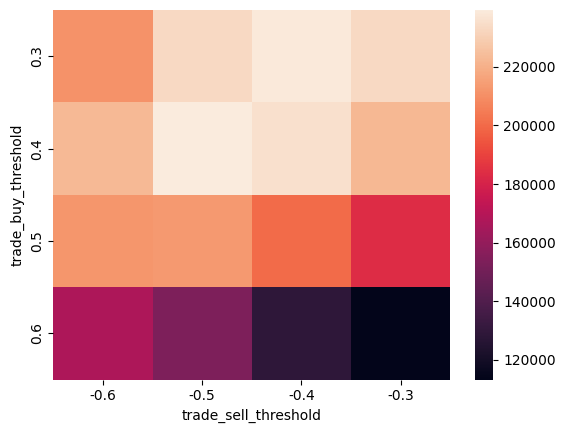

In [39]:
htmap = data.groupby(['trade_buy_threshold', 'trade_sell_threshold']).agg({
    'final_portfolio_value': 'mean'
}).pivot_table(index=['trade_buy_threshold'], columns='trade_sell_threshold', values='final_portfolio_value')
sns.heatmap(htmap)
plt.show()